# Model Hierarchical Alignment

This notebook visualizes how deep neural network layer representations align with brain ROIs across the model hierarchy. We interpolate RSA scores along network depth for selected ROIs and generate summary curves, multi‑panel figures, and cortical surface maps.


## 1. Imports

Import essential libraries for data manipulation, statistical analysis, and visualization, as well as project‑specific utilities for alignment interpolation and plotting. We also configure global plotting styles for consistency.


In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import seaborn as sns

from convergence.plotting import plot_faverage_parcelation
from convergence.figures import add_pvalue_bracket, plot_cbar, setup_matplotlib_fonts
from convergence.operations import interpolate_alignment_series, unpack_scores
from convergence.figures_utils import add_cluster, proccess_alignment

setup_matplotlib_fonts()

## 2. Input Data Paths

Define the file system paths for all required inputs and outputs:
- **HCP atlas metadata**: `hcp.csv` (Glasser et al., 2016)  
- **Model information**: `models-info.csv`  
- **RSA p-values**: `rsa_pvalues_subject_language_vision.parquet`  
- **Subject–subject RSA alignments** (joined & separated hemispheres)  
- **Subject–model RSA alignments** (joined & separated hemispheres)  
- **Output directory** for generated figures  


### 2.1 Required Filenames for Figures

Specify the exact filenames and directories used:
- `data_folder`, `hcp_filename`, `models_filename`  
- `nsd_folder`, `pvalues_filename`  
- `intersubject_shift1_joined_filename`  
- `intersubject_shift1_separated_filename`  
- `model_brain_joined_filename`  
- `model_brain_separated_filename`  
- `output` directory for saving figures  


In [2]:
# Required filenames for the figures
data_folder = Path("../derivatives")
hcp_filename = data_folder / "metadata" / "hcp.csv"
models_filename = data_folder / "metadata" / "models-info.csv"
nsd_folder = data_folder / "nsd"
pvalues_filename = nsd_folder / "rsa_pvalues_subject_language_vision.parquet"
intersubject_shift1_joined_filename = (
    nsd_folder / "rsa_subject_subject_alignment_shift_1_joined.parquet"
)
intersubject_shift1_separated_filename = (
    nsd_folder / "rsa_subject_subject_alignment_shift_1_separated.parquet"
)
model_brain_joined_filename = nsd_folder / "rsa_subject_model_alignment_joined.parquet"
model_brain_separated_filename = nsd_folder / "rsa_subject_model_alignment_separated.parquet"

# Output folder for figures
figure_folder = Path("../figures")
output = figure_folder / "03_rsa_model_hierarchy"
output.mkdir(exist_ok=True, parents=True)

## 3. Model–Brain Alignment Series

Compute and interpolate RSA alignment between model layers and brain ROIs. This series captures how alignment evolves across network depth for each subject and ROI.


### 3.1 Series Overview

1. Select a subset of ROIs of interest.  
2. Aggregate RSA scores by `(subject, ROI, model, layer)`.  
3. Interpolate the alignment series across layers to obtain smooth curves.  
4. Merge interpolated scores with ROI metadata (names, areas, colors) for plotting.


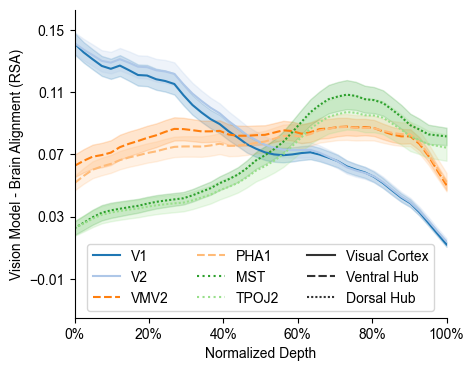

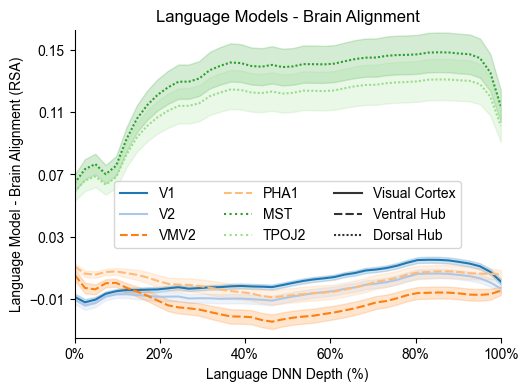

In [3]:
hcp = pd.read_csv(hcp_filename)
df_model_info = pd.read_csv(models_filename)
selected_rois = ["V1","V2","V3","V4","V8",
                 "PHA1", "PHA2", "PHA3", "VMV1", "VMV2", "VMV3", "FFC",
                 "VVC", "V4t", "FST", "MST", "MT", "TPOJ3", "TPOJ2",
                 ]
roi_list = hcp[hcp.name.isin(selected_rois)].roi.unique()
df = pd.read_parquet(model_brain_joined_filename)
df = df.query("roi in @roi_list and similarity < 1 and similarity > -1")
df_g = df.groupby(["roi", "model", "layer", "subject"]).similarity.mean().reset_index()
df_g = df_g.rename(columns={"similarity": "score"})
df_interpolated = interpolate_alignment_series(df_g, groups=["subject", "roi", "model"])
df_interpolated = unpack_scores(df_interpolated)
df_interpolated = df_interpolated.rename(columns={"model": "model_name"})
df_interpolated = df_interpolated.merge(df_model_info, on="model_name")
df_interpolated = (
    df_interpolated.groupby(["subject", "roi", "modality", "layer"]).score.mean().reset_index()
)
df_interpolated["depth"] = df_interpolated["layer"] / df_interpolated["layer"].max()
df_interpolated = df_interpolated.merge(hcp[["roi", "name", "area", "area_color"]], on="roi")
df_interpolated_all = df_interpolated.copy()


hue_order = [
    "V1",
    "V2",
    "VMV2",
    "PHA1",
    "MST",
    "TPOJ2",
]
style_order = ["Visual Cortex", "Ventral Hub", "Dorsal Hub"]
df_interpolated_selected = df_interpolated.query("name in @hue_order").copy()

palette = (
    df_interpolated_selected[["name", "area_color"]]
    .drop_duplicates()
    .set_index("name")
    .to_dict()["area_color"]
)
add_cluster(df_interpolated_selected)
df_interpolated_selected.cluster = df_interpolated_selected.cluster.str.replace("Cluster", "Hub")

fig, ax = plt.subplots(1, 1, figsize=(4 * (6 / 5), 4))
# fig2, ax2 = plt.subplots(1, 1, figsize=(4*(6/5), 4))
fig2, ax2 = plt.subplots(1, 1, figsize=(5.5, 4))
sns.lineplot(
    data=df_interpolated_selected.query("modality=='vision'"),
    x="depth",
    y="score",
    hue="name",
    hue_order=hue_order,
    errorbar="se",
    ax=ax,
    style="cluster",
    palette=palette,
    style_order=style_order,
)


# 3 column legend and remove both titles (seaborn adds titles as "name" and "cluster" as entries)

handles, labels = ax.get_legend_handles_labels()  # Remove first and 6th entry
handles = handles[1:7] + handles[8:]
labels = labels[1:7] + labels[8:]

# Make handles 2,3 dashed
handles[2].set_linestyle("--")
handles[3].set_linestyle("--")
# Make handles 4,5 dotted
handles[4].set_linestyle(":")
handles[5].set_linestyle("dotted")

ax.set_xlim(0, 1)
sns.despine(ax=ax)


sns.lineplot(
    data=df_interpolated_selected.query("modality=='language'"),
    x="depth",
    y="score",
    hue="name",
    hue_order=hue_order,
    errorbar="se",
    ax=ax2,
    style="cluster",
    palette=palette,
    legend=True,
    style_order=style_order,
)

sns.despine(ax=ax2)
ax2.set_ylim(-0.035, 0.163)
ax.set_ylim(-0.035, 0.163)
ax2.set_xlim(0, 1)
ax.legend(handles=handles, labels=labels, title="", ncol=3, loc="lower center")
# ax.yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f'))
ax.yaxis.set_major_locator(mticker.MultipleLocator(0.04, offset=-0.01))
ax2.yaxis.set_major_locator(mticker.MultipleLocator(0.04, offset=-0.01))
ax.set_ylabel("Vision Model - Brain Alignment (RSA)")
ax2.set_ylabel("Language Model - Brain Alignment (RSA)")

ax.xaxis.set_major_formatter(mticker.PercentFormatter(1, 0))
ax2.xaxis.set_major_formatter(mticker.PercentFormatter(1, 0))


ax.set_xlabel("Normalized Depth")
ax2.set_xlabel("Language DNN Depth (%)")


handles, labels = ax2.get_legend_handles_labels()  # Remove first and 6th entry
handles = handles[1:7] + handles[8:]
labels = labels[1:7] + labels[8:]

# Make handles 2,3 dashed
handles[2].set_linestyle("--")
handles[3].set_linestyle("--")
# Make handles 4,5 dotted
handles[4].set_linestyle(":")
handles[5].set_linestyle("dotted")
ax2.legend(
    handles=handles, labels=labels, title="", ncol=3, loc="center", bbox_to_anchor=(0.5, 0.4)
)
ax2.set_title("Language Models - Brain Alignment")

fig.savefig(output / "01_rsa_models_vision_depth.pdf", bbox_inches="tight", transparent=True)
fig2.savefig(output / "02_rsa_models_language_depth.pdf", bbox_inches="tight", transparent=True)

## 4. Multi‑Panel Visualization of Alignment Series

Create a composite figure with a custom mosaic layout:
- **Panels A–C**: Layerwise alignment curves for Early Visual, Ventral, and LOTC hubs.  
- **Panel F**: Legend and annotations.  
- **Panel D**: Boxplot of peak alignment depths across ROIs, grouped by functional cluster.


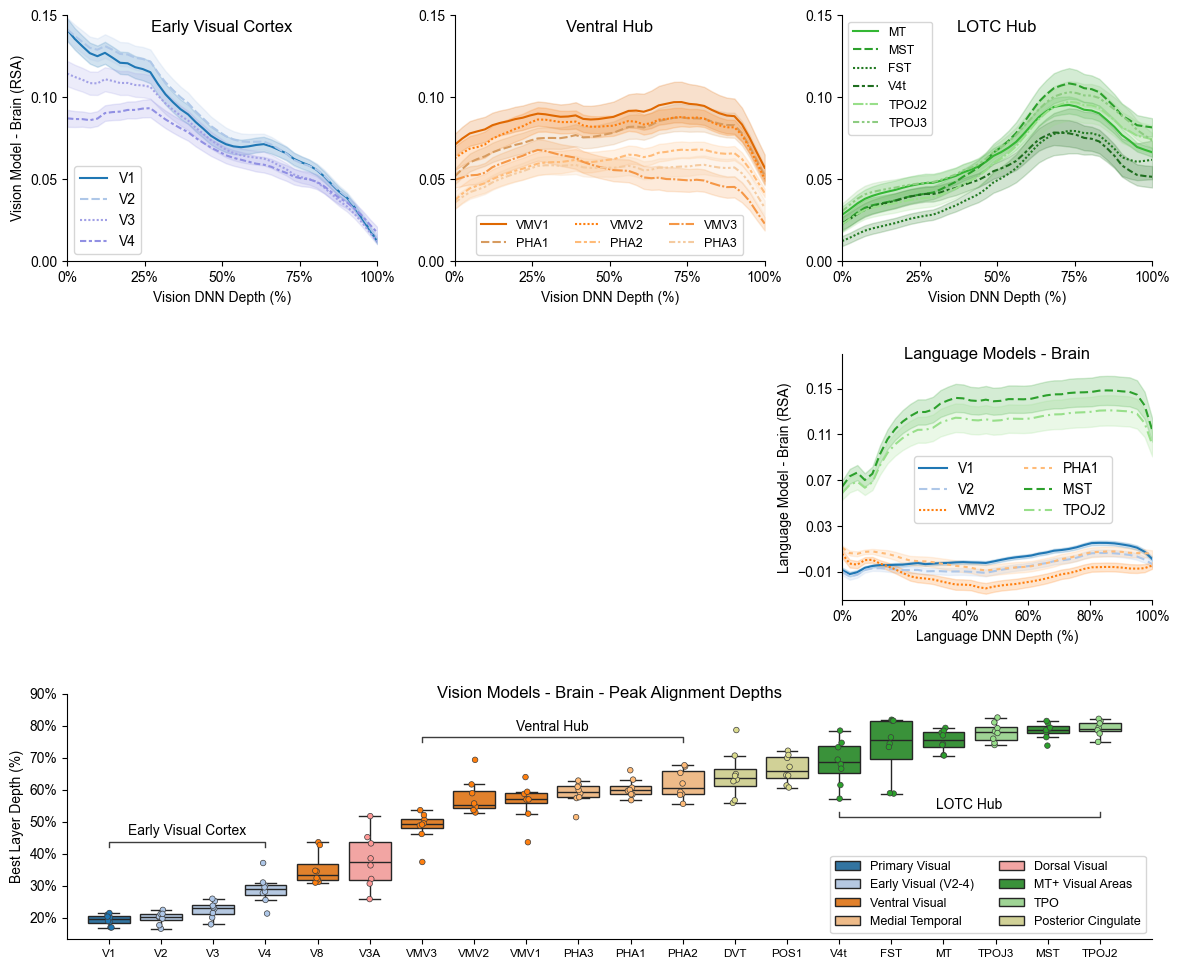

In [4]:

# Creat a matplotlib mosaic
layout = [
    ["A", "B", "C"],
    ["F", "F", "E"],
    ["D", "D", "D"],
]

# Create the figure and axes all at once from the mosaic increase heigh spacing margin
fig, axes_dict = plt.subplot_mosaic(
    layout, figsize=(14, 12), gridspec_kw={"hspace": 0.38, "wspace": 0.25}
)

# Define palette for the different areas
ax1 = axes_dict["A"]
ax2 = axes_dict["B"]
ax3 = axes_dict["C"]
ax_f = axes_dict["F"]
ax_f.axis("off")

palette_evc = {
    "V1": "#1f77b4",
    "V2": "#aec7e8",
    "V3": "#a2a1e6",
    "V4": "#9190e3",
}
palette_ventral = {
    "VMV1": "#df6801",
    "VMV2": "#ff7f0e",
    "VMV3": "#f59746",
    "PHA1": "#d79b5f",
    "PHA2": "#ffbb78",
    "PHA3": "#f5cba0",
}

palette_lotc = {
    "MT": "#34B734",
    "MST": "#2ca02c",
    "FST": "#217921",
    "V4t": "#1F6E1F",
    "TPOJ2": "#98df8a",
    "TPOJ3": "#8dcc81",
}

# Plot curves for each hub
sns.lineplot(
    data=df_interpolated_all.query("modality=='vision' and name in ['V1', 'V2', 'V3', 'V4']"),
    x="depth",
    y="score",
    hue="name",
    hue_order=["V1", "V2", "V3", "V4"],
    errorbar="se",
    ax=ax1,
    palette=palette_evc,
    style="name",
    style_order=["V1", "V2", "V3", "V4"],
)


sns.lineplot(
    data=df_interpolated_all.query(
        "modality=='vision' and name in ['VMV1', 'VMV2', 'VMV3', 'PHA1', 'PHA2', 'PHA3']"
    ),
    x="depth",
    y="score",
    hue="name",
    hue_order=["VMV1", "PHA1", "VMV2", "PHA2", "VMV3", "PHA3"],
    errorbar="se",
    ax=ax2,
    palette=palette_ventral,
    style="name",
    style_order=["VMV1", "PHA1", "VMV2", "PHA2", "VMV3", "PHA3"],
)


sns.lineplot(
    data=df_interpolated_all.query(
        "modality=='vision' and name in ['MT', 'MST', 'FST', 'V4t', 'TPOJ2', 'TPOJ3']"
    ),
    x="depth",
    y="score",
    hue="name",
    hue_order=["MT", "MST", "FST", "V4t", "TPOJ2", "TPOJ3"],
    errorbar="se",
    ax=ax3,
    style="name",
    palette=palette_lotc,
    style_order=["MT", "MST", "FST", "V4t", "TPOJ2", "TPOJ3"],
)

# Formatting panel
for i, ax in enumerate([ax1, ax2, ax3]):
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 0.15)
    sns.despine(ax=ax)
    if i == 0:
        ax.set_ylabel("Vision Model - Brain (RSA)")
    else:
        ax.set_ylabel("")
    ax.set_xlabel("Vision DNN Depth (%)")
    ax.xaxis.set_major_formatter(mticker.PercentFormatter(1, 0))
    ax.xaxis.set_major_locator(mticker.MultipleLocator(0.25))
    ax.yaxis.set_major_locator(mticker.MultipleLocator(0.05))
    n_col = 1 if i != 1 else 2
    ax.legend(title="", ncol=n_col)
# Reduce the space between the titles and the axes
ax1.set_title("Early Visual Cortex", y=0.9)
ax2.set_title("Ventral Hub", y=0.9)
ax3.set_title("LOTC Hub", y=0.9)
# Set ax2 legend to bottom center
ax2.legend(title="", ncol=3, loc="lower center", fontsize=9)
ax1.legend(title="", ncol=1, loc="lower left")
ax3.legend(title="", ncol=1, loc="best", fontsize=9)

ax = axes_dict["D"]


# Get tables with all discrete stats (included pvalues and depth of convergence)
df_comparison_subjects = proccess_alignment(
    models_filename=models_filename,
    models_alignment_filename=model_brain_joined_filename,
    subject_alignment_filename=intersubject_shift1_joined_filename,
    pvalues_filename=pvalues_filename,
    hcp_filename=hcp_filename,
    group_subject=False,
)

df_comparison = proccess_alignment(
    models_filename=models_filename,
    models_alignment_filename=model_brain_joined_filename,
    subject_alignment_filename=intersubject_shift1_joined_filename,
    pvalues_filename=pvalues_filename,
    hcp_filename=hcp_filename,
    group_subject=True,
)
top_n = 20
top_rois = df_comparison.sort_values("intersubject_rsa", ascending=False).head(top_n).name.tolist()
top_rois = df_comparison.sort_values("vision_rsa", ascending=False).head(top_n).name.tolist()
# x_order = df_comparison.query("name in @top_rois").sort_values("intersubject_rsa", ascending=False).sort_values("vision_depth").name.tolist()

# Sort by quantile 25
x_order = (
    df_comparison_subjects.query("name in @top_rois")
    .groupby("name")
    .vision_depth.quantile()
    .sort_values()
    .index.tolist()
)

palette = (
    df_comparison[["area", "area_color"]]
    .drop_duplicates()
    .set_index("area")
    .to_dict()["area_color"]
)
hue_order = (
    df_comparison.query("name in @top_rois")
    .sort_values("area_id")
    .drop_duplicates("area_id")
    .area.tolist()
)

# fig, ax = plt.subplots(1, 1, figsize=(10, 4), dpi=300)
# fig, ax = plt.subplots(1, 1, figsize=(9.5, 3.2), dpi=300)
sns.boxplot(
    data=df_comparison_subjects.query("name in @top_rois"),
    x="name",
    y="vision_depth",
    ax=ax,
    order=x_order,
    hue="area",
    palette=palette,
    hue_order=hue_order,
    showfliers=False,
)
# Add points with jitter
sns.stripplot(
    data=df_comparison_subjects.query("name in @top_rois"),
    x="name",
    y="vision_depth",
    ax=ax,
    order=x_order,
    hue="area",
    palette=palette,
    hue_order=hue_order,
    dodge=False,
    jitter=0.05,
    s=4,
    linewidth=0.5,
    edgecolor=(0.24, 0.24, 0.24),
    alpha=1,
    marker="o",
    zorder=100,
    legend=False,
)

ax.set_xticks(np.arange(len(x_order)))
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=8.5)
sns.despine(ax=ax)
# Remove legend title
ax.legend(title="", ncol=2, loc="lower right", fontsize=9)  # , bbox_to_anchor=(0.95, 0.0))
ax.set_xlabel("")
ax.set_ylabel("Best Layer Depth (%)")
ax.yaxis.set_major_formatter(mticker.PercentFormatter(1, 0))

ax.set_ylim(None, 0.9)
ax.set_xlim(-0.8, len(x_order))
add_pvalue_bracket(ax=ax, x1=0, x2=3, y=0.42, height=0.015, text="Early Visual Cortex", y_text=0.46)
add_pvalue_bracket(ax=ax, x1=6, x2=11, y=0.75, height=0.015, text="Ventral Hub", y_text=0.785)
add_pvalue_bracket(ax=ax, x1=14, x2=19, y=0.53, height=-0.015, text="LOTC Hub", y_text=0.54)

hcp = pd.read_csv(hcp_filename)
df_model_info = pd.read_csv(models_filename)
selected_rois = [
    "V1",
    "V2",
    "V3",
    "V4",
    "V8",
    "PHA1",
    "PHA2",
    "PHA3",
    "VMV1",
    "VMV2",
    "VMV3",
    "FFC",
    "VVC",
    "V4t",
    "FST",
    "MST",
    "MT",
    "TPOJ3",
    "TPOJ2",
]
roi_list = hcp[hcp.name.isin(selected_rois)].roi.unique()

hue_order = [
    "V1",
    "V2",
    "VMV2",
    "PHA1",
    "MST",
    "TPOJ2",
]
style_order = ["Visual Cortex", "Ventral Hub", "LOTC Hub"]
df_interpolated_selected = df_interpolated.query("name in @hue_order").copy()
palette = (
    df_interpolated_selected[["name", "area_color"]]
    .drop_duplicates()
    .set_index("name")
    .to_dict()["area_color"]
)
add_cluster(df_interpolated_selected)
df_interpolated_selected.cluster = df_interpolated_selected.cluster.str.replace("Cluster", "Hub")
df_interpolated_selected.cluster = df_interpolated_selected.cluster.str.replace("Dorsal", "LOTC")

ax2 = axes_dict["E"]

sns.lineplot(
    data=df_interpolated_selected.query("modality=='language'"),
    x="depth",
    y="score",
    hue="name",
    hue_order=hue_order,
    errorbar="se",
    ax=ax2,
    style="name",
    palette=palette,
    legend=True,
    dashes={
        # Solid line
        "V1": (None, None),
        # Dashed line (--)
        "V2": (4, 2),
        # Dotted line (:)
        "VMV2": (1, 1),
        # Dashed line (--)
        "PHA1": (2, 2),
        # Dashed line with longer strokes (--)
        "MST": (4, 2),
        # Dash-dot line (-.-)
        "TPOJ2": (5, 2, 1, 2),
    },
)


sns.despine(ax=ax2)
ax2.set_ylim(-0.035, 0.18)
ax2.set_xlim(0, 1)
ax2.yaxis.set_major_locator(mticker.MultipleLocator(0.04, offset=-0.01))
ax2.set_ylabel("Language Model - Brain (RSA)")
ax2.xaxis.set_major_formatter(mticker.PercentFormatter(1, 0))
ax2.set_xlabel("Language DNN Depth (%)")

handles, labels = ax2.get_legend_handles_labels()  # Remove first and 6th entry
ax2.legend(
    handles=handles, labels=labels, title="", ncol=2, loc="center", bbox_to_anchor=(0.55, 0.45)
)
ax2.set_title("Language Models - Brain", y=0.95)
ax.set_title("Vision Models - Brain - Peak Alignment Depths", y=0.95)

# Save the figure
fig.savefig(
    output / "03_rsa_models_vision_language_depth_hubs_curves.pdf",
    bbox_inches="tight",
    transparent=True,
)

## 5. Cortical Surface Maps of Peak Alignment Depth

Render group‑averaged “best layer” depths onto the fsaverage cortical surface for each hemisphere. Only ROIs with highly significant inter‑subject alignment (p < 0.001) are shown, colored by their normalized peak depth in the vision model.


In [5]:
df_comparison_asymmetry = proccess_alignment(
    models_filename=models_filename,
    models_alignment_filename=model_brain_separated_filename,
    subject_alignment_filename=intersubject_shift1_separated_filename,
    pvalues_filename=pvalues_filename,
    hcp_filename=hcp_filename,
    group_subject=True,
)
rois_significant = df_comparison_asymmetry.query("intersubject_p_value <0.001").name.tolist()

normalize = 0.2, 0.8
df_comparison_asymmetry_plot = df_comparison_asymmetry.query("name in @rois_significant").copy()

views = ["lateral", "medial", "ventral", "caudal"]
hemispheres = ["lh", "rh"]


depth_folder = output / "04_depth_cortical"
depth_folder.mkdir(exist_ok=True, parents=True)

for hemisphere in hemispheres:
    brain = plot_faverage_parcelation(
        df_comparison_asymmetry_plot[["name", "mne_name", "vision_depth"]],
        value_column="vision_depth",
        cmap="PRGn_r",
        default_value=None,
        default_color="lightgray",
        normalize=normalize,
        size=(1600, 1200),
        hemisphere=hemisphere,
    )
    for view in views:
        brain.show_view(view)
        brain.save_image(depth_folder / f"04_depth_cortical_{hemisphere}_{view}.png", mode="rgba")
        brain.save_image(depth_folder / f"04_depth_cortical_{hemisphere}_{view}.tiff", mode="rgba")
    brain.close()

Inspect the generated surface plots to ensure correct alignment and visualization.

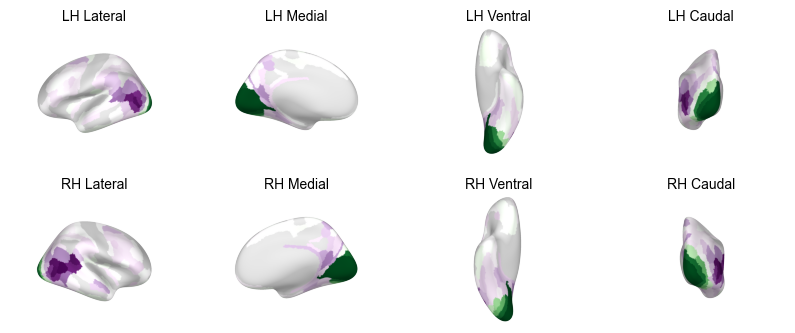

In [6]:
fig, axes = plt.subplots(len(hemispheres), len(views), figsize=(10, 4))
for i, hemisphere in enumerate(hemispheres):
    for j, view in enumerate(views):
        img_file = depth_folder / f"04_depth_cortical_{hemisphere}_{view}.png"
        img = plt.imread(img_file)
        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        axes[i, j].set_title(f"{hemisphere.upper()} {view.capitalize()}", fontsize=10)
        

## 6. Colorbars for Depth Maps

Generate horizontal and vertical colorbars for the depth maps, mapping the best vision‑DNN layer (20 %–80 % depth) to a diverging PiYG_r colormap, with percentage labels.


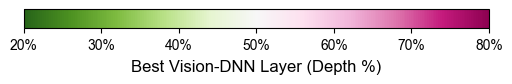

In [7]:
# Make an horizontal colorbar RdBu_r from 0.2 to 0.8
fig_cbar, ax_cbar = plot_cbar(
    cmap="PiYG_r",
    title="Best Vision-DNN Layer (Depth %)",
    vmin=0.2,
    vmax=0.8,
    locator=0.1,
    horizontal=True,
    percent=True,
    rotation=0,
    labelpad=5,
    figsize=(6, 0.25),
)
fig_cbar.savefig(
    depth_folder / f"04_colorbar_depth_cortical_0.2_0.8.pdf", bbox_inches="tight", dpi=300, transparent=True
)

fig_cbar, ax_cbar = plot_cbar(
    cmap="PiYG_r",
    title="Best Vision-DNN Layer (Depth %)",
    vmin=0.2,
    vmax=0.8,
    locator=0.1,
    horizontal=False,
    percent=True,
    rotation=90,
    labelpad=5,
    figsize=(0.25, 4),
)
fig_cbar.savefig(
    depth_folder / f"04_colorbar_depth_cortical_0.2_0.8_vertical.pdf",
    bbox_inches="tight",
    dpi=300,
    transparent=True,
)
# Close second fig for better notebook rendering
plt.close(fig_cbar)

## 7. ROI Depth Curves by Area – Vision Models

Plot normalized depth‑aligned RSA curves for each anatomical area, restricted to ROIs with significant inter‑subject alignment (p < 0.01). Arrange 3×5 subplots, one per area, sharing axes for comparison.


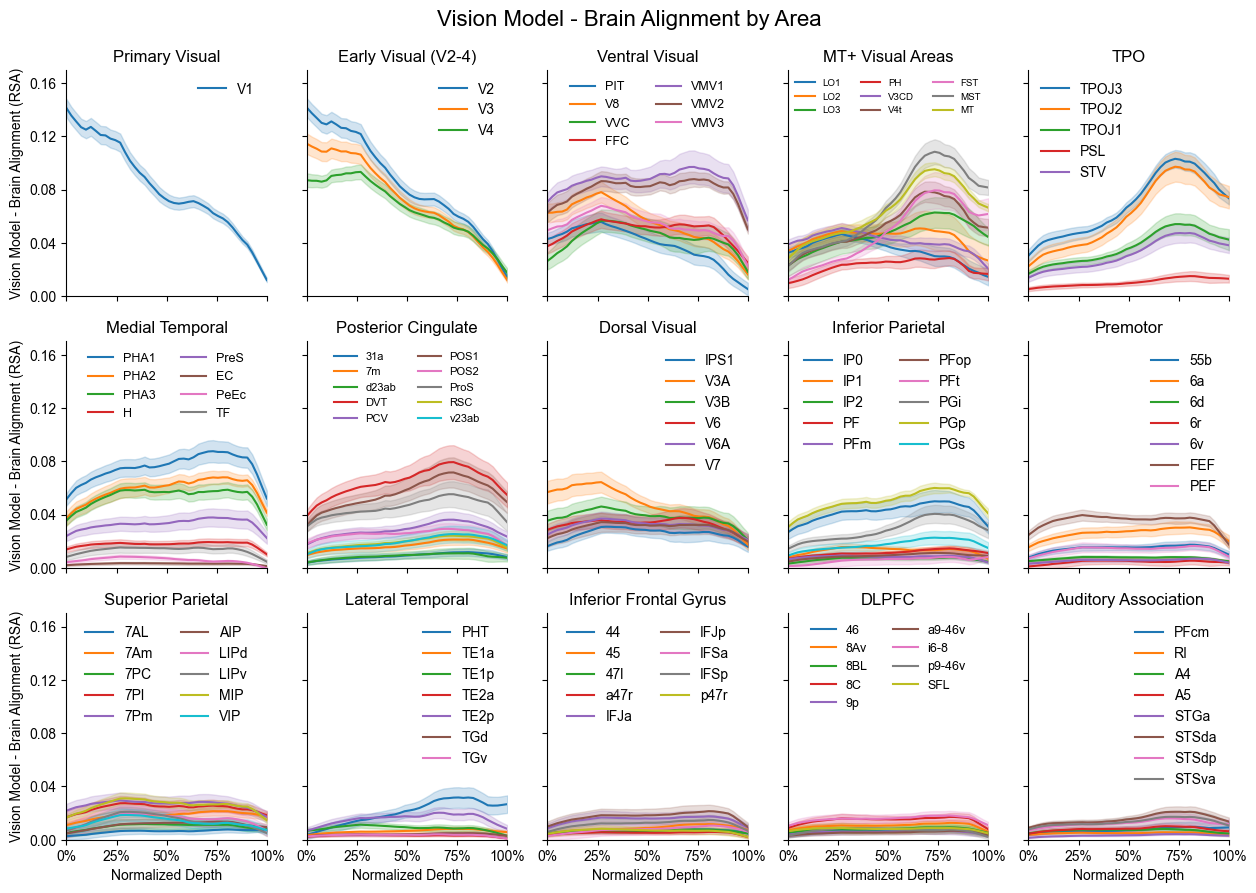

In [8]:
df = pd.read_parquet(model_brain_joined_filename)
hcp = pd.read_csv(hcp_filename)
df = df.query("similarity < 1 and similarity > -1")
df_g = df.groupby(["roi", "model", "layer", "subject"]).similarity.mean().reset_index()
df_g = df_g.rename(columns={"similarity": "score"})
df_interpolated = interpolate_alignment_series(df_g, groups=["subject", "roi", "model"])
df_interpolated = unpack_scores(df_interpolated)
df_interpolated = df_interpolated.rename(columns={"model": "model_name"})
df_interpolated = df_interpolated.merge(df_model_info, on="model_name")
df_interpolated = (
    df_interpolated.groupby(["subject", "roi", "modality", "layer"]).score.mean().reset_index()
)
df_interpolated["depth"] = df_interpolated["layer"] / df_interpolated["layer"].max()
df_interpolated = df_interpolated.merge(hcp[["roi", "name", "area", "area_color"]], on="roi")


df_comparison = proccess_alignment(
    models_filename=models_filename,
    models_alignment_filename=model_brain_joined_filename,
    subject_alignment_filename=intersubject_shift1_joined_filename,
    pvalues_filename=pvalues_filename,
    hcp_filename=hcp_filename,
    group_subject=True,
)


significant_rois = df_comparison[df_comparison.intersubject_p_value < 0.01].name.tolist()

hcp = pd.read_csv(hcp_filename).sort_values(["area_id", "roi_order"])


df_comparison_areas = (
    df_comparison.groupby(["area"])
    .aggregate({"intersubject_rsa": "mean", "vision_rsa": "max", "language_rsa": "mean"})
    .reset_index()
)
area_order = df_comparison_areas.sort_values("vision_rsa", ascending=False).area.tolist()
# Shape 0 and 1 position
area_order[0], area_order[1] = area_order[1], area_order[0]


modality = "vision"
# 22 subplots -> 4 columns, 6 rows
# Add a little the height margin between subplots
fig, axes = plt.subplots(3, 5, figsize=(15, 10), sharex=True, sharey=True)
axes_flatten = axes.flatten()
for i, area in enumerate(area_order[:15]):
    df_subplot = df_interpolated.query(
        "modality==@modality and area==@area and name in @significant_rois"
    )

    # Hue order
    hue_order = (
        hcp.query("area==@area and name in @significant_rois and roi<=180")
        .sort_values("roi_order")
        .name.tolist()
    )

    ax = axes_flatten[i]
    sns.lineplot(
        data=df_subplot,
        x="depth",
        y="score",
        hue="name",
        ax=ax,
        errorbar="se",
        legend=True,
        hue_order=hue_order,
    )
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 0.17)
    sns.despine(ax=ax)
    ax.set_title(area)
    # Remove title of the legend
    ax.legend(title="", loc="best", frameon=False)
    ax.set_xlabel("")
    ax.set_ylabel("")
    # Set yticks 0.04
    ax.yaxis.set_major_locator(mticker.MultipleLocator(0.04))
    ax.xaxis.set_major_formatter(mticker.PercentFormatter(1, 0))
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.2f"))

# Modify legends
positions = [
    (2, 2, 9),
    (3, 3, 7),
    (5, 2, 9),
    (6, 2, 8),
    (8, 2, 10),
    (10, 2, 10),
    (12, 2, 10),
    (13, 2, 9),
]
for pos, ncol, fontsize in positions:
    axes_flatten[pos].legend(
        title="", ncol=ncol, loc="upper center", fontsize=fontsize, frameon=False
    )
for pos in [0, 5, 10]:
    axes_flatten[pos].set_ylabel("Vision Model - Brain Alignment (RSA)")
for pos in [10, 11, 12, 13, 14]:
    axes_flatten[pos].set_xlabel("Normalized Depth")

fig.suptitle("Vision Model - Brain Alignment by Area", fontsize=16, y=0.94)
fig.savefig(output / "05_vision_depth_curves_area.pdf", bbox_inches="tight", transparent=True)

## 8. ROI Depth Curves by Area – Language Models

As above, but for the language model alignment curves. Each area’s subplot shows how RSA varies with network depth, with a horizontal reference line at zero.


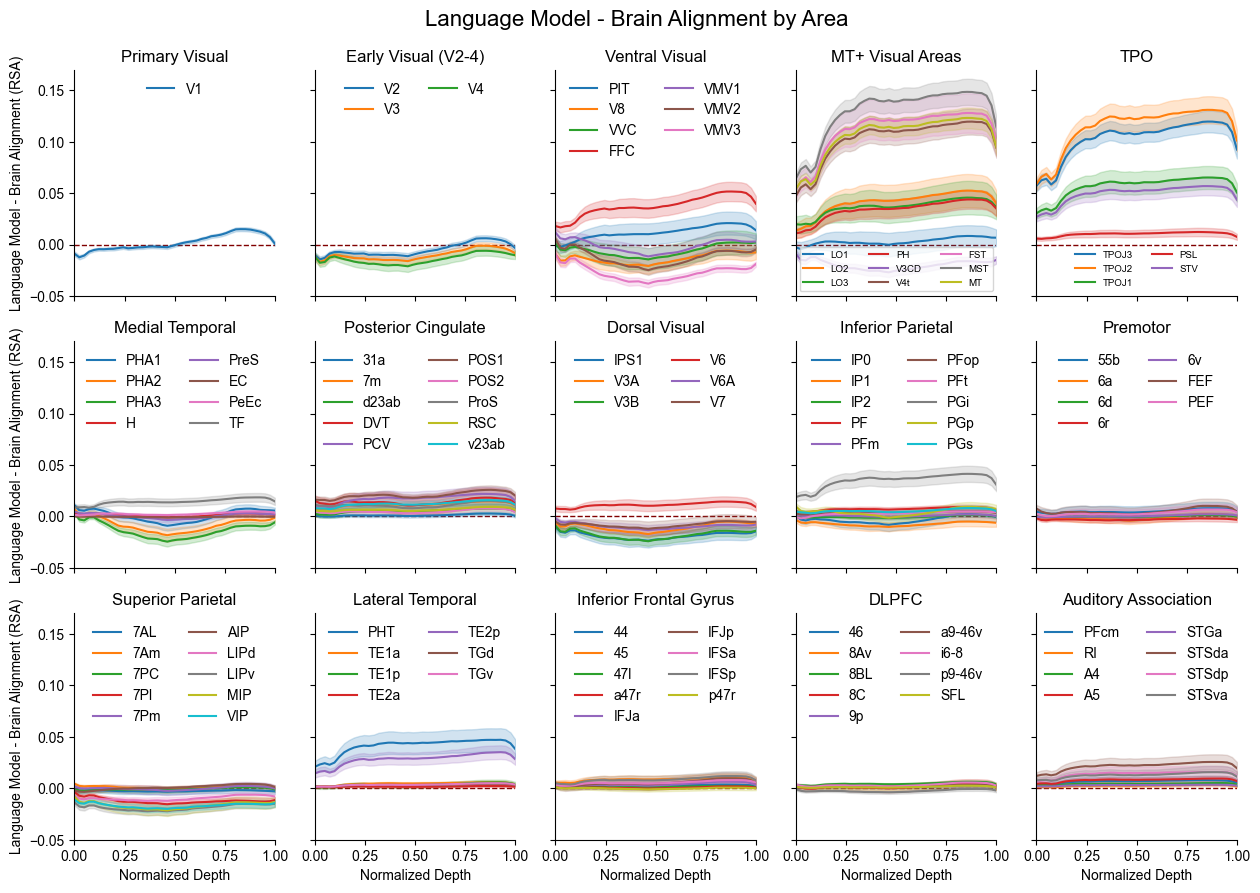

In [9]:
hcp = pd.read_csv(hcp_filename).sort_values(["area_id", "roi_order"])


df_comparison_areas = (
    df_comparison.groupby(["area"])
    .aggregate({"intersubject_rsa": "mean", "vision_rsa": "max", "language_rsa": "mean"})
    .reset_index()
)
area_order = df_comparison_areas.sort_values("vision_rsa", ascending=False).area.tolist()
# Shape 0 and 1 position
area_order[0], area_order[1] = area_order[1], area_order[0]

modality = "language"
fig, axes = plt.subplots(3, 5, figsize=(15, 10), sharex=True, sharey=True)
# fig, axes = plt.subplots(5, 5, figsize=(15, 15), sharex=True, sharey=True)
axes_flatten = axes.flatten()
for i, area in enumerate(area_order[:15]):
    df_subplot = df_interpolated.query(
        "modality==@modality and area==@area and name in @significant_rois"
    )
    hue_order = (
        hcp.query("area==@area and name in @significant_rois and roi<=180")
        .sort_values("roi_order")
        .name.tolist()
    )
    ax = axes_flatten[i]
    sns.lineplot(
        data=df_subplot,
        x="depth",
        y="score",
        hue="name",
        ax=ax,
        errorbar="se",
        legend=True,
        hue_order=hue_order,
    )
    ax.set_xlim(0, 1)
    sns.despine(ax=ax)
    ax.set_title(area)
    ax.hlines(0, 0, 1, color="maroon", linestyle="--", linewidth=1, zorder=-10)
    ax.set_ylim(-0.05, 0.17)
    ax.legend(title="", loc="upper center", frameon=False, ncol=2)

axes_flatten[4].legend(title="", loc="lower center", frameon=False, ncol=2, fontsize=7)
axes_flatten[3].legend(title="", loc="lower center", frameon=True, ncol=3, fontsize=7)

for pos in [0, 5, 10]:
    axes_flatten[pos].set_ylabel("Language Model - Brain Alignment (RSA)")
for pos in [10, 11, 12, 13, 14]:
    axes_flatten[pos].set_xlabel("Normalized Depth")

fig.suptitle("Language Model - Brain Alignment by Area", fontsize=16, y=0.94)
fig.savefig(
    output / "06_language_depth_curves_area.pdf", bbox_inches="tight", dpi=300, transparent=True
)

## 9. Alignment Series Grouped by Model Family

Display depth‑alignment curves for a small set of ROIs, grouped by model “family” (e.g., transformer, vision‑only) to highlight how architectural lineage influences the depth at which peak alignment occurs. Use a 3×4 grid of family panels.


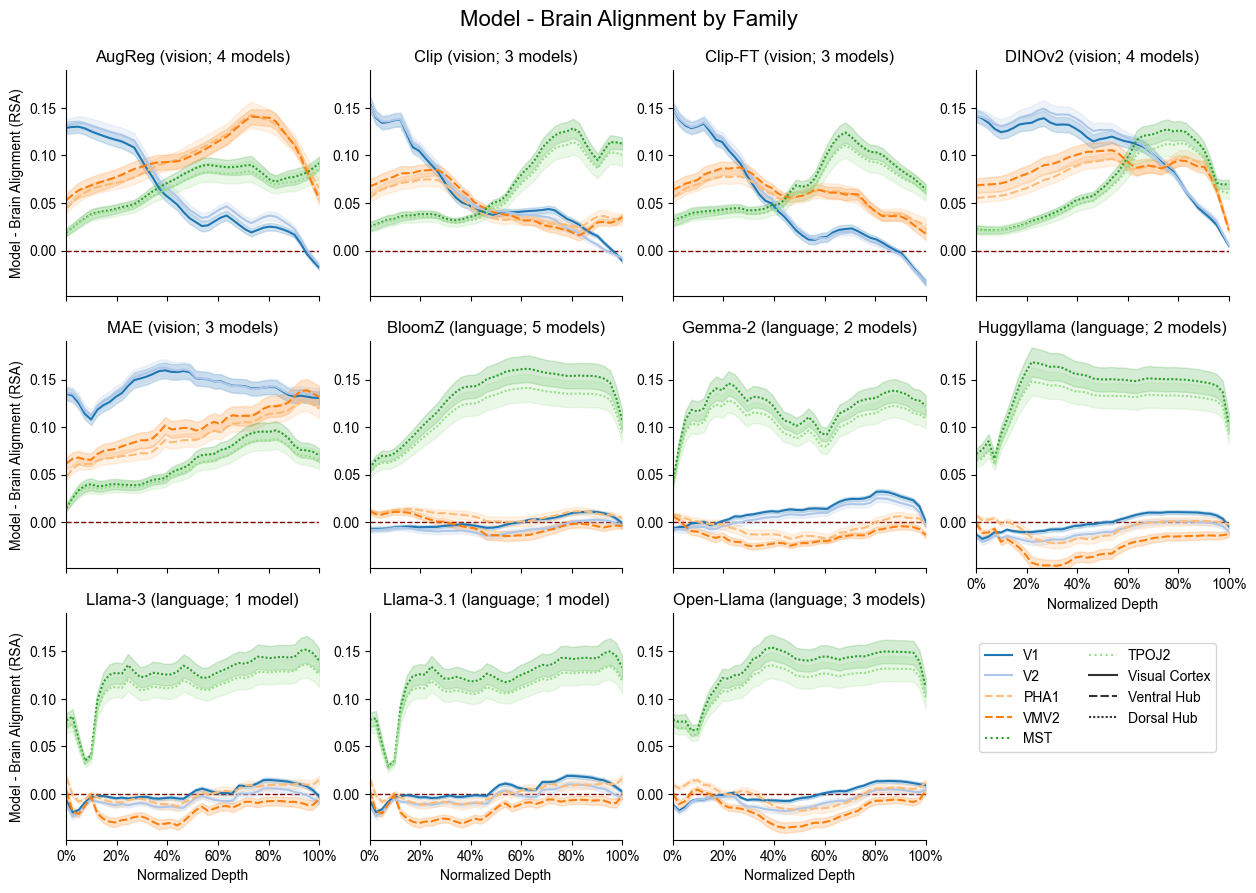

In [10]:
hcp = pd.read_csv(hcp_filename)
df_model_info = pd.read_csv(models_filename)
selected_rois = ["V1", "V2", "PHA1", "VMV2", "MST", "TPOJ2"]
roi_list= hcp[hcp.name.isin(selected_rois)].roi.unique()
df = pd.read_parquet(model_brain_joined_filename)
df = df.query("roi in @roi_list and similarity < 1 and similarity > -1")
df_g = df.groupby(["roi", "model", "layer", "subject"]).similarity.mean().reset_index()
df_g = df_g.rename(columns={"similarity": "score"})
df_interpolated = interpolate_alignment_series(df_g, groups=["subject", "roi", "model"])
df_interpolated = unpack_scores(df_interpolated)
df_interpolated = df_interpolated.rename(columns={"model": "model_name"})
df_interpolated = df_interpolated.merge(df_model_info, on="model_name")
df_interpolated = df_interpolated.groupby(["subject", "roi", "modality", "family", "layer"]).score.mean().reset_index()
df_interpolated["depth"] = df_interpolated["layer"] / df_interpolated["layer"].max()
df_interpolated = df_interpolated.merge(hcp[["roi", "name", "area", "area_color"]], on="roi")
add_cluster(df_interpolated)
df_interpolated.cluster = df_interpolated.cluster.str.replace("Cluster", "Hub")

style_order = ["Visual Cortex", "Ventral Hub", "Dorsal Hub"]

fig, axes = plt.subplots(3, 4, figsize=(15, 10), sharex=False, sharey=False)
axes_flatten = axes.flatten()
family_order = (
    df_interpolated[["modality", "family"]]
    .drop_duplicates()
    .sort_values(["modality", "family"], ascending=[False, True])
    .family.tolist()
)

palette = (
    hcp.query("name in @selected_rois")[["name", "area_color"]]
    .drop_duplicates()
    .set_index("name")
    .to_dict()["area_color"]
)
n_models = df_model_info.groupby("family").model_name.count().to_dict()
for i, family in enumerate(family_order):
    df_interpolated_family = df_interpolated.query("family==@family")
    modality = df_interpolated_family.modality.iloc[0]
    hue_order = selected_rois
    n_models_family = n_models[family]

    ax = axes_flatten[i]
    sns.lineplot(
        data=df_interpolated_family,
        x="depth",
        y="score",
        hue="name",
        ax=ax,
        errorbar="se",
        hue_order=hue_order,
        palette=palette,
        style="cluster",
        style_order=style_order,
    )
    sns.despine(ax=ax)
    ax.set_title(
        f"{family} ({modality}; {n_models_family} model{'s' if n_models_family > 1 else ''})"
    )
    ax.set_xlim(0, 1)
    ax.set_ylabel("")
    ax.set_xlabel("")
    if i not in [7, 8, 9, 10]:
        # Remove xticklabels
        ax.set_xticklabels([])

    # If is not the last remove the legend
    ax.set_ylim(-0.048, 0.19)
    ax.plot([0, 1], [0, 0], color="maroon", linestyle="--", linewidth=1, zorder=-10)

    if i != 10:
        ax.get_legend().remove()
    else:
        # Remove handle and legend number 0 and 4
        handles, labels = ax.get_legend_handles_labels()
        handles = handles[1:7] + handles[8:]
        labels = labels[1:7] + labels[8:]
        # Set dashed to 2 and 3
        handles[2].set_linestyle("--")
        handles[3].set_linestyle("--")
        # Set dotted to 4 and 5
        handles[4].set_linestyle(":")
        handles[5].set_linestyle("dotted")
        ax.legend(
            handles=handles,
            labels=labels,
            title="",
            loc="upper center",
            ncol=2,
            frameon=True,
            bbox_to_anchor=(1.68, 0.9),
        )

    if i >= 7:
        ax.set_xlabel("Normalized Depth")
        ax.xaxis.set_major_formatter(mticker.PercentFormatter(1, 0))
    # Format 0.00

    # yaxis %
    ax.yaxis.set_major_formatter(mticker.PercentFormatter(1, 0))

axes_flatten[-1].axis("off")
for ax in axes_flatten[::-1]:
    ax.yaxis.set_major_formatter(mticker.FormatStrFormatter("%.2f"))
    # ax.hlines(0, 0, 1, color="maroon", linestyle="--", linewidth=1, zorder=-10)
    # ax.plot([0, 1], [0, 0], color="maroon", linestyle="--", linewidth=1, zorder=-10)

axes_flatten[0].set_ylabel("Model - Brain Alignment (RSA)")
axes_flatten[4].set_ylabel("Model - Brain Alignment (RSA)")
axes_flatten[8].set_ylabel("Model - Brain Alignment (RSA)")

fig.suptitle("Model - Brain Alignment by Family", fontsize=16, y=0.94)
fig.savefig(
    output / "07_model_depth_curves_family.pdf", bbox_inches="tight", dpi=300, transparent=True
)